# Simulating Ultra narrowband Metasurface

In this simulation of [Paper Link](https://duke.box.com/s/owa6sdzf80y0u7xjp1qxia62md6z514q), I did 1200-1600nm parameter sweep, and linear polarization. Finding the transmittance of this structure.

![Figure from paper](../assets/ultranarrow.png)

---

![](../assets/geomp_structure2.png)

---

![](../assets/power_geom.png)

---

![](../assets/runtimes.png)

---

## Circular Polarization

![](../assets/power_circular_big.png)

## Circular Zoomed in

![](../assets/power_circular.png)

## LCP / (LCP + RCP)

![](../assets/power_lcprcp.png)

---

## Preconditions

In [1]:
# Import the necessary packages
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
import tidy3d.web as web
from tidy3d import material_library
import scienceplots

td.config.logging_level = "ERROR"

In [2]:
# 0 Define a FreqRange object with desired wavelengths
fr = td.FreqRange.from_wvl_interval(wvl_min=1.2, wvl_max=1.6)
N = 501 # num_points
fwidth = fr.fmax - fr.fmin
freq0 = fr.freq0
lda0 = td.C_0 / fr.freq0

In [3]:
# 1 Computational Domain Size
h = 0.210  # Height of cylinder
spc = 8
sh = 3  # height of the SiO2
Lz = spc + h + spc + h

Px = Py = P = 0.750 # periodicity
sim_size = [Px, Py, Lz]

---

In [4]:
# 2 Grid Resolution
dl = P / 32
horizontal_grid = td.UniformGrid(dl=dl)
vertical_grid = td.AutoGrid(min_steps_per_wvl=32)
grid_spec=td.GridSpec(
    grid_x=horizontal_grid,
    grid_y=horizontal_grid,
    grid_z=vertical_grid,
)

In [5]:
# 3 Structures and Materials
R = 0.235  # radius of the cylinder
r = 0.030  # radius of the inner hole
p = 0.080  # distance between hole to center of circle
theta = np.deg2rad(90) # angle between x-axis and p vector

Si = material_library['cSi']['Green2008']
SiO2 = material_library['SiO2']['Horiba']

outer_cylinder = td.Cylinder(
    center=[0, 0, h / 2], 
    radius=R, 
    length=h, 
    axis=2
)

inner_cylinder = td.Cylinder(
    center=[p*np.cos(theta), -p*np.sin(theta), h / 2], 
    radius=r, 
    length=h, 
    axis=2
)

cylinder = td.ClipOperation(
    operation="difference",
    geometry_a=outer_cylinder,
    geometry_b=inner_cylinder
)

atom = td.Structure(
    geometry=cylinder, 
    medium=Si,
    name="metaatom"
)

dioxide = td.Structure(
    geometry=td.Box(
        center=[0,0,-sh/2],
        size=(td.inf,td.inf, sh)
    ),
    medium=SiO2, 
    name="silicon dioxide"
)

substrate = td.Structure(
    geometry=td.Box(
        center=(0,0,-Lz/2),
        size=(td.inf,td.inf,2 * (spc - (sh - h)))
    ),
    medium=Si,
    name='substrate'
)

---

In [6]:
source = td.PlaneWave(
    source_time=td.GaussianPulse(freq0=fr.freq0, fwidth=fwidth),
    size=(td.inf, td.inf, 0),
    center=(0, 0, -Lz/2 + spc - (sh - h) - 0.5 * lda0),
    direction="+",
    pol_angle=0,
)

In [8]:
monitor = td.FluxMonitor(
    center=(0, 0, Lz/2 - spc + 1.5 * lda0),
    size=(td.inf, td.inf, 0),
    freqs=fr.freqs(N),
    name="flux_monitor"
)

---

In [9]:
bandwidth = fr.fmax - fr.fmin
run_time = 500 / bandwidth # run_time for the transmittance simulation

In [10]:
bc = td.BoundarySpec(
    x=td.Boundary.periodic(), 
    y=td.Boundary.periodic(), 
    z=td.Boundary.pml()
)

## Simulation

In [11]:
sim_empty = td.Simulation(
    size=sim_size,
    grid_spec=grid_spec,
    structures=[substrate, dioxide],
    sources=[source],
    monitors=[monitor],
    run_time=run_time,
    boundary_spec=bc
)

sim_actual = td.Simulation(
    size=sim_size,
    grid_spec=grid_spec,
    structures=[substrate, dioxide, atom],
    sources=[source],
    monitors=[monitor],
    run_time=run_time,
    boundary_spec=bc
)

In [12]:
sims = {
    "actual": sim_actual,
    "norm": sim_empty
}

In [13]:
sims["actual"].plot_3d()

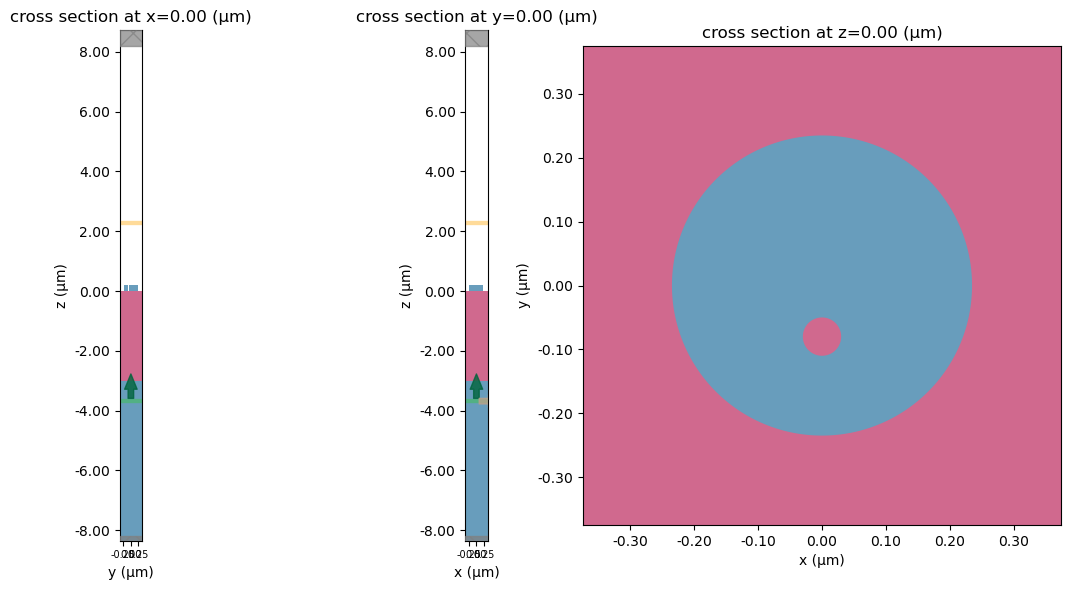

In [14]:
# Always visualize simulation before running
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(12, 6))
ax1.tick_params(axis='x', labelsize=7)
ax2.tick_params(axis='x', labelsize=7)
sims["actual"].plot(x=0, ax=ax1)
# sim_actual.plot_grid(x=0, ax=ax1)
sims["actual"].plot(y=0, ax=ax2)
# sim_actual.plot_grid(y=0, ax=ax2)
sims["actual"].plot(z=0, ax=ax3)
# sim_actual.plot_grid(z=0, ax=ax3)
plt.savefig(f'geomp_structure.png', dpi=300)
plt.show()

In [15]:
batch = web.Batch(simulations=sims, verbose=True)
batch_data = batch.run(path_dir="data/geom_linear2")

Output()

22:38:50 EDT Started working on Batch containing 2 tasks.

22:38:52 EDT Maximum FlexCredit cost: 0.370 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

22:38:53 EDT Batch complete.

Output()

## Postprocess

In [16]:
T_actual = batch_data["actual"]["flux_monitor"].flux 
T_norm = batch_data["norm"]["flux_monitor"].flux

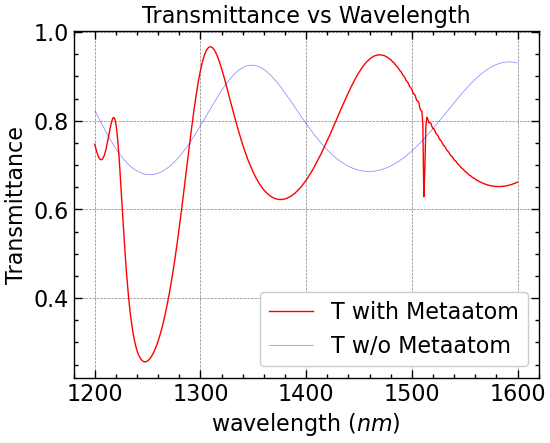

In [17]:
# this uses scienceplots to make plots look better
plt.style.use(['science', 'notebook', 'grid'])
# plot transmission, compare to paper results, look similar
fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))
plt.plot(td.C_0 / fr.freqs(N) * 1000, T_actual, "r", lw=1, label="T with Metaatom")
plt.plot(td.C_0 / fr.freqs(N) * 1000, T_norm, "b", lw=0.5, alpha=0.5, label="T w/o Metaatom")
plt.xlabel(r"wavelength ($nm$)")
plt.ylabel("Transmittance")
plt.legend()
plt.title("Transmittance vs Wavelength")
plt.savefig("power_geom", dpi=300)
plt.show()

## Circular Polarization

In [22]:
def circular_polarized_plane_wave(pol):
    # define a plane wave polarized in the x direction
    plane_wave_x = td.PlaneWave(
        source_time=td.GaussianPulse(freq0=fr.freq0, fwidth=fwidth),
        size=(td.inf, td.inf, 0),
        center=(0, 0, -Lz/2 + spc - (sh - h) - 0.5 * lda0),
        direction="+",
        pol_angle=0,
    )

    # determine the phase difference given the polarization
    if pol == "left":
        phase = -np.pi / 2
    elif pol == "right":
        phase = np.pi / 2
    else:
        raise ValueError("pol must be `left` or `right`")

    # define a plane wave polarized in the y direction with a phase difference
    plane_wave_y = td.PlaneWave(
        source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth, phase=phase),
        size=(td.inf, td.inf, 0),
        center=(0, 0,-Lz/2 + spc - (sh - h) - 0.5 * lda0),
        direction="+",
        pol_angle=np.pi / 2,
    )

    return [plane_wave_x, plane_wave_y]


In [23]:
def make_sim(pol):
    sim = td.Simulation(
        size=sim_size,
        grid_spec=grid_spec,
        structures=[substrate, dioxide, atom],
        sources=circular_polarized_plane_wave(pol),
        monitors=[monitor],
        run_time=run_time,
        boundary_spec=bc
    )
    return sim

In [24]:
sim_left = make_sim("left")
sim_left.plot_3d()

In [26]:
# define simulations
sims = {
    "LCP": sim_left,
    "RCP": make_sim("right")
}


In [27]:
# create a batch and run all sims in parallel
batch = web.Batch(simulations=sims)
batch_results = batch.run(path_dir="data/circular")

Output()

22:55:09 EDT Started working on Batch containing 2 tasks.

22:55:11 EDT Maximum FlexCredit cost: 0.379 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

22:56:55 EDT Batch complete.

Output()

In [29]:
T_lcp = batch_results["LCP"]["flux_monitor"].flux 
T_rcp = batch_results["RCP"]["flux_monitor"].flux

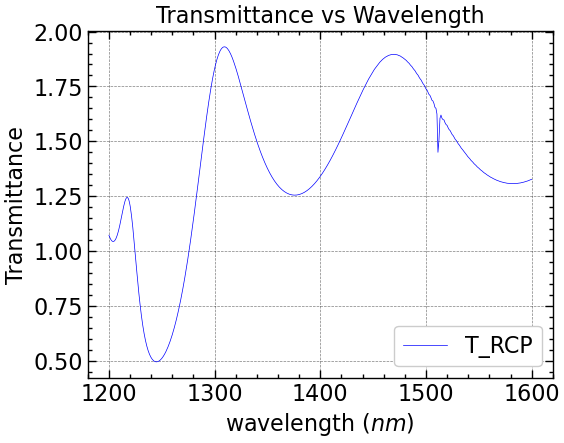

In [36]:
# this uses scienceplots to make plots look better
plt.style.use(['science', 'notebook', 'grid'])
# plot transmission, compare to paper results, look similar
fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))
# plt.plot(td.C_0 / fr.freqs(N) * 1000, T_lcp, "r", lw=1, label="T_LCP")
plt.plot(td.C_0 / fr.freqs(N) * 1000, T_rcp, "b", lw=0.5, alpha=1, label="T_RCP")
plt.xlabel(r"wavelength ($nm$)")
plt.ylabel("Transmittance")
plt.legend()
plt.title("Transmittance vs Wavelength")
plt.savefig("power_geom", dpi=300)
plt.show()

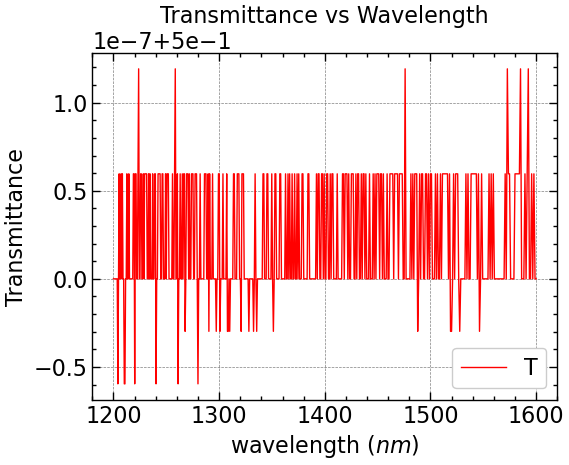

In [34]:
# this uses scienceplots to make plots look better
plt.style.use(['science', 'notebook', 'grid'])
# plot transmission, compare to paper results, look similar
fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))
plt.plot(td.C_0 / fr.freqs(N) * 1000, T_lcp / (T_lcp + T_rcp), "r", lw=1, label="T")
# plt.plot(td.C_0 / fr.freqs(N) * 1000, T_rcp, "b", lw=0.5, alpha=1, label="T_RCP")
plt.xlabel(r"wavelength ($nm$)")
plt.ylabel("Transmittance")
plt.legend()
plt.title("Transmittance vs Wavelength")
plt.savefig("power_geom", dpi=300)
plt.show()